# Supplemental Figure 7

- Panel A: Blur distribution across channels and plate
- Panel B: Saturation distribution for all channels combined across plates

## Import libraries

In [31]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(grid))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(readr))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(purrr))
suppressPackageStartupMessages(library(tidyr))

## Set paths

In [32]:
figure_dir <- "../figures/supplementary"
output_supp_figure <- file.path(figure_dir, "supp_figure_7_qualitycontrol.png")

In [33]:
# Base directory containing Plate_ folders
plates_dir <- "/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/image_quality_control/"

# List all Image.csv files in Plate_ folders except Plate_4
image_csv_paths <- list.files(
  path = plates_dir,
  pattern = "Image\\.csv$",
  recursive = TRUE,
  full.names = TRUE
) %>%
  # Keep only paths that contain "Plate_" in the directory and exclude Plate_4
  keep(~ str_detect(.x, "Plate_") && !str_detect(.x, "Plate_4"))

# Read all Image.csv files and bind into one dataframe
image_data_df <- image_csv_paths %>%
  set_names() %>%
  map_dfr(read_csv, .id = "source_file", show_col_types = FALSE)

# Add Metadata_Plate column (capture Plate_3_prime and similar names)
image_data_df <- image_data_df %>%
  mutate(
    Metadata_Plate = str_extract(source_file, "Plate_\\d+(_[A-Za-z0-9]+)?"),
    Metadata_Plate = ifelse(is.na(Metadata_Plate), "Unknown", Metadata_Plate)
  )

# Check result
dim(image_data_df)
head(image_data_df)

[1] 7272   87

source_file,Channel_OrigCY5,Channel_OrigDAPI,Channel_OrigGFP,Channel_OrigRFP,ExecutionTime_01Images,ExecutionTime_02Metadata,ExecutionTime_03NamesAndTypes,ExecutionTime_04Groups,ExecutionTime_05MeasureImageQuality,⋯,Series_OrigRFP,URL_OrigCY5,URL_OrigDAPI,URL_OrigGFP,URL_OrigRFP,Width_OrigCY5,Width_OrigDAPI,Width_OrigGFP,Width_OrigRFP,Metadata_Plate
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/image_quality_control//qc_results/Plate_3/Image.csv,-1,-1,-1,-1,0,0,1.26,0,2.61,⋯,0,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_3_10_CY5_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_1_10_DAPI_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_2_10_GFP_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_4_10_RFP_001.tif,1224,1224,1224,1224,Plate_3
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/image_quality_control//qc_results/Plate_3/Image.csv,-1,-1,-1,-1,0,0,1.40,0,1.45,⋯,0,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_3_11_CY5_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_1_11_DAPI_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_2_11_GFP_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_4_11_RFP_001.tif,1224,1224,1224,1224,Plate_3
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/image_quality_control//qc_results/Plate_3/Image.csv,-1,-1,-1,-1,0,0,1.11,0,1.55,⋯,0,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_3_12_CY5_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_1_12_DAPI_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_2_12_GFP_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_4_12_RFP_001.tif,1224,1224,1224,1224,Plate_3
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/image_quality_control//qc_results/Plate_3/Image.csv,-1,-1,-1,-1,0,0,0.65,0,1.44,⋯,0,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_3_13_CY5_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_1_13_DAPI_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_2_13_GFP_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_4_13_RFP_001.tif,1224,1224,1224,1224,Plate_3
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/image_quality_control//qc_results/Plate_3/Image.csv,-1,-1,-1,-1,0,0,0.68,0,1.36,⋯,0,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_3_14_CY5_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_1_14_DAPI_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_2_14_GFP_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_4_14_RFP_001.tif,1224,1224,1224,1224,Plate_3
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/image_quality_control//qc_results/Plate_3/Image.csv,-1,-1,-1,-1,0,0,0.60,0,1.26,⋯,0,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_3_15_CY5_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_1_15_DAPI_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_2_15_GFP_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_4_15_RFP_001.tif,1224,1224,1224,1224,Plate_3


In [34]:
# Rename plates in Metadata_Plate
image_data_df <- image_data_df %>%
    mutate(
        Metadata_Plate = recode(
            Metadata_Plate,
            "Plate_3" = "Plate A",
            "Plate_3_prime" = "Plate B",
            "Plate_5" = "Plate C",
            "Plate_6" = "Plate D"
        )
    )

# Check result
unique(image_data_df$Metadata_Plate)

[1] "Plate A" "Plate B" "Plate C" "Plate D"

In [35]:
# Add Metadata_Well and Metadata_Site columns
image_data_df <- image_data_df %>%
  mutate(
    Metadata_Well = str_split_fixed(FileName_OrigRFP, "_", n = 6)[, 1],
    Metadata_Site = str_split_fixed(FileName_OrigRFP, "_", n = 6)[, 4]
  )

dim(image_data_df)
head(image_data_df)

[1] 7272   89

source_file,Channel_OrigCY5,Channel_OrigDAPI,Channel_OrigGFP,Channel_OrigRFP,ExecutionTime_01Images,ExecutionTime_02Metadata,ExecutionTime_03NamesAndTypes,ExecutionTime_04Groups,ExecutionTime_05MeasureImageQuality,⋯,URL_OrigDAPI,URL_OrigGFP,URL_OrigRFP,Width_OrigCY5,Width_OrigDAPI,Width_OrigGFP,Width_OrigRFP,Metadata_Plate,Metadata_Well,Metadata_Site
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/image_quality_control//qc_results/Plate_3/Image.csv,-1,-1,-1,-1,0,0,1.26,0,2.61,⋯,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_1_10_DAPI_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_2_10_GFP_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_4_10_RFP_001.tif,1224,1224,1224,1224,Plate A,B10,10
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/image_quality_control//qc_results/Plate_3/Image.csv,-1,-1,-1,-1,0,0,1.40,0,1.45,⋯,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_1_11_DAPI_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_2_11_GFP_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_4_11_RFP_001.tif,1224,1224,1224,1224,Plate A,B10,11
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/image_quality_control//qc_results/Plate_3/Image.csv,-1,-1,-1,-1,0,0,1.11,0,1.55,⋯,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_1_12_DAPI_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_2_12_GFP_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_4_12_RFP_001.tif,1224,1224,1224,1224,Plate A,B10,12
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/image_quality_control//qc_results/Plate_3/Image.csv,-1,-1,-1,-1,0,0,0.65,0,1.44,⋯,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_1_13_DAPI_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_2_13_GFP_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_4_13_RFP_001.tif,1224,1224,1224,1224,Plate A,B10,13
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/image_quality_control//qc_results/Plate_3/Image.csv,-1,-1,-1,-1,0,0,0.68,0,1.36,⋯,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_1_14_DAPI_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_2_14_GFP_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_4_14_RFP_001.tif,1224,1224,1224,1224,Plate A,B10,14
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/image_quality_control//qc_results/Plate_3/Image.csv,-1,-1,-1,-1,0,0,0.60,0,1.26,⋯,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_1_15_DAPI_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_2_15_GFP_001.tif,file:/home/jenna/nf1_cellpainting_data/0.download_data/Plate_3/B10_01_4_15_RFP_001.tif,1224,1224,1224,1224,Plate A,B10,15


In [36]:
qc_results_df <- image_data_df %>%
    select(
        starts_with("Metadata_") 
        | contains("PowerLogLogSlope")
        | contains("PercentMaximal")
    )
dim(qc_results_df)
head(qc_results_df)

[1] 7272   13

Metadata_Frame,Metadata_Series,Metadata_Plate,Metadata_Well,Metadata_Site,ImageQuality_PowerLogLogSlope_OrigCY5,ImageQuality_PowerLogLogSlope_OrigDAPI,ImageQuality_PowerLogLogSlope_OrigGFP,ImageQuality_PowerLogLogSlope_OrigRFP,ImageQuality_PercentMaximal_OrigCY5,ImageQuality_PercentMaximal_OrigDAPI,ImageQuality_PercentMaximal_OrigGFP,ImageQuality_PercentMaximal_OrigRFP
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,Plate A,B10,10,-1.811780,-2.169082,-2.125140,-1.751400,9.037538e-05,0.061455261,0.011116172,0.0039765169
0,0,Plate A,B10,11,-1.985002,-2.288957,-2.094239,-1.843569,4.861292e-01,0.254768205,0.238319885,0.2620886113
0,0,Plate A,B10,12,-1.905199,-2.212145,-2.197451,-1.840352,7.546344e-02,0.024401353,0.015906067,0.0006326277
0,0,Plate A,B10,13,-1.953310,-2.259287,-2.149918,-1.801441,5.567124e-02,0.016900197,0.016900197,0.0228649719
0,0,Plate A,B10,14,-1.725033,-2.311723,-2.037359,-1.658721,1.807508e-04,0.106371826,0.005603274,0.0215093412
0,0,Plate A,B10,15,-1.829097,-2.283226,-2.057677,-1.563095,9.037538e-05,0.006597403,0.059015125,0.0176231997


In [37]:
channels <- c("OrigDAPI", "OrigGFP", "OrigRFP", "OrigCY5")

qc_df <- bind_rows(lapply(channels, function(channel) {
  qc_results_df %>%
    select(
      starts_with("Metadata_"),
      all_of(paste0("ImageQuality_PowerLogLogSlope_", channel)),
      all_of(paste0("ImageQuality_PercentMaximal_", channel))
    ) %>%
    rename(
      PowerLogLogSlope = paste0("ImageQuality_PowerLogLogSlope_", channel),
      PercentMaximal = paste0("ImageQuality_PercentMaximal_", channel)
    ) %>%
    mutate(Channel = channel)
}))

# Remove Orig prefix from Channel column
qc_df <- qc_df %>%
  mutate(
    Channel = str_replace(Channel, "^Orig", ""),  # Remove 'Orig' prefix from values
    Channel = factor(Channel, levels = c("DAPI", "GFP", "CY5", "RFP"))  # Set factor levels
  )

dim(qc_df)
head(qc_df)

[1] 29088     8

Metadata_Frame,Metadata_Series,Metadata_Plate,Metadata_Well,Metadata_Site,PowerLogLogSlope,PercentMaximal,Channel
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>
0,0,Plate A,B10,10,-2.169082,0.061455261,DAPI
0,0,Plate A,B10,11,-2.288957,0.254768205,DAPI
0,0,Plate A,B10,12,-2.212145,0.024401353,DAPI
0,0,Plate A,B10,13,-2.259287,0.016900197,DAPI
0,0,Plate A,B10,14,-2.311723,0.106371826,DAPI
0,0,Plate A,B10,15,-2.283226,0.006597403,DAPI


## Plot the blur metric per channel across plates

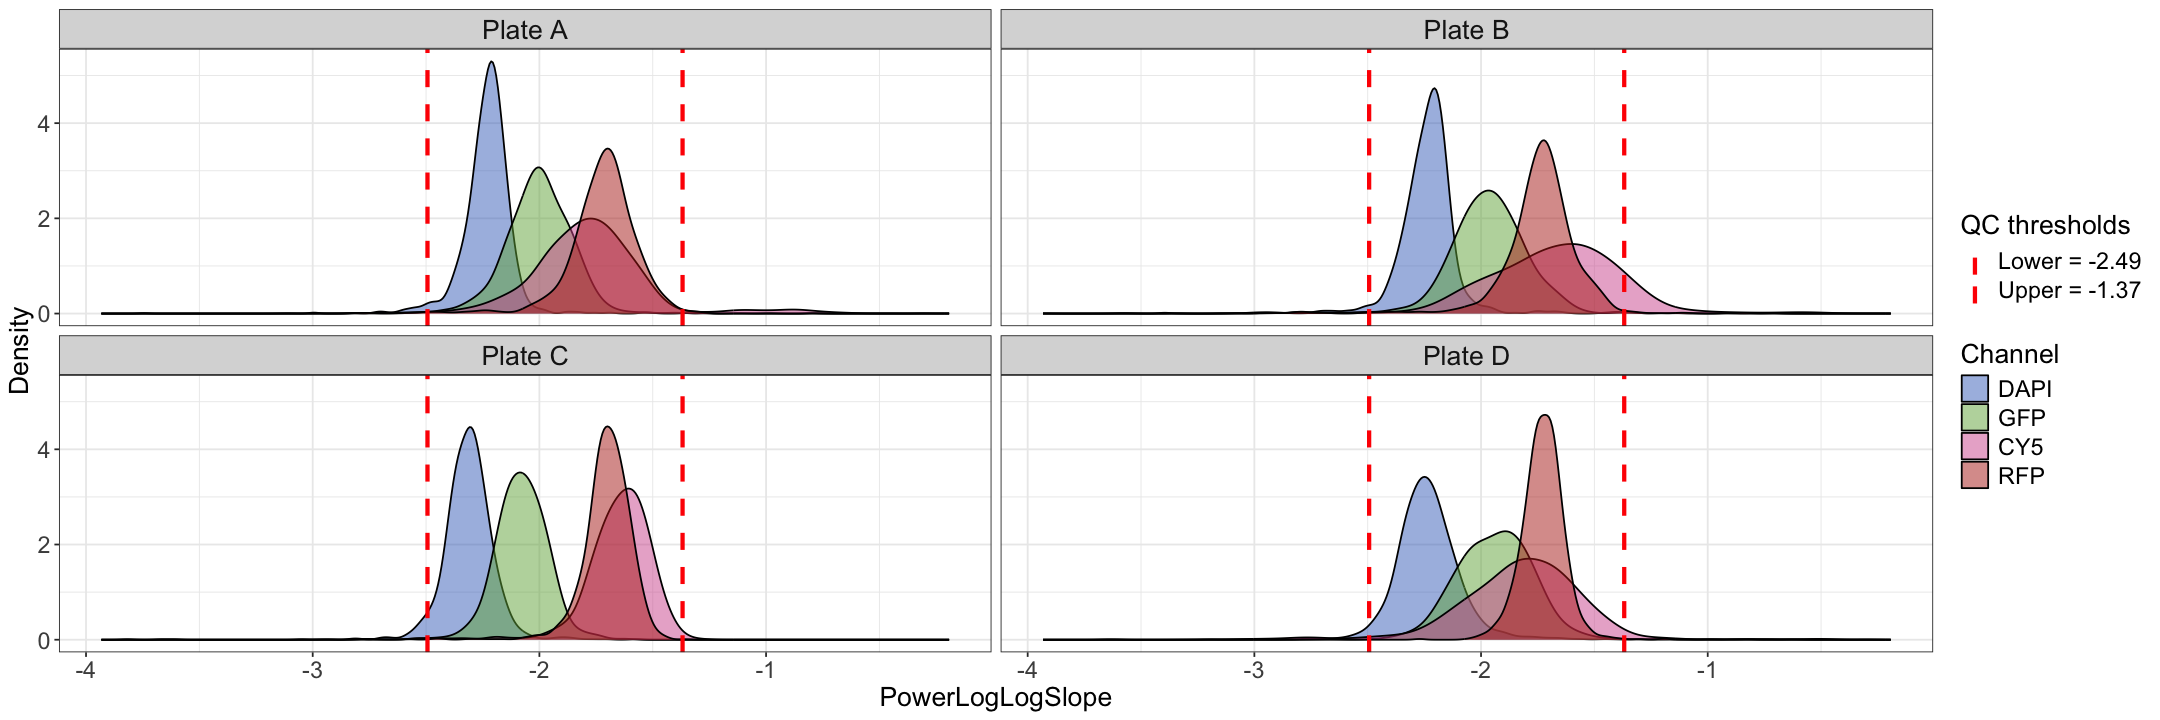

In [38]:
width <- 18
height <- 6
options(repr.plot.width = width, repr.plot.height = height) 

# Threshold values
upper_threshold <- -1.36839084751248
lower_threshold <- -2.4936740062477365

# Create the plot with the specified color mapping
qc_blur_plot <- ggplot(qc_df, aes(x = PowerLogLogSlope, fill = Channel)) +
    geom_density(alpha = 0.5, adjust = 1.5) + 
    scale_fill_manual(
        values = c("DAPI" = "#4472C4",  # Blue
                   "GFP" = "#70AD47",  # Green
                   "CY5" = "#D35B9D",  # Brighter magenta
                   "RFP" = "#b42718")  # Red
    ) +
    geom_vline(aes(xintercept = upper_threshold, color = paste("Upper =", round(upper_threshold, 2))), 
               linetype = "dashed", linewidth = 1.2) + 
    geom_vline(aes(xintercept = lower_threshold, color = paste("Lower =", round(lower_threshold, 2))), 
               linetype = "dashed", linewidth = 1.2) +  
    scale_color_manual(name = "QC thresholds", values = c("Upper = -1.37" = "red", 
                                                          "Lower = -2.49" = "red")) +  # Set the color and label for the legend
    labs(
        x = "PowerLogLogSlope",
        y = "Density"
    ) +
    theme_bw() +
    facet_wrap(~ Metadata_Plate) +  # Facet by plate
    theme(
        strip.text = element_text(size = 16),   # Facet titles
        axis.title = element_text(size = 16),  # Axis titles
        axis.text = element_text(size = 14),   # Axis text
        legend.title = element_text(size = 16), # Legend title
        legend.text = element_text(size = 14)   # Legend text
    )

qc_blur_plot


## Plot saturation metric combining all channels comparing by plate

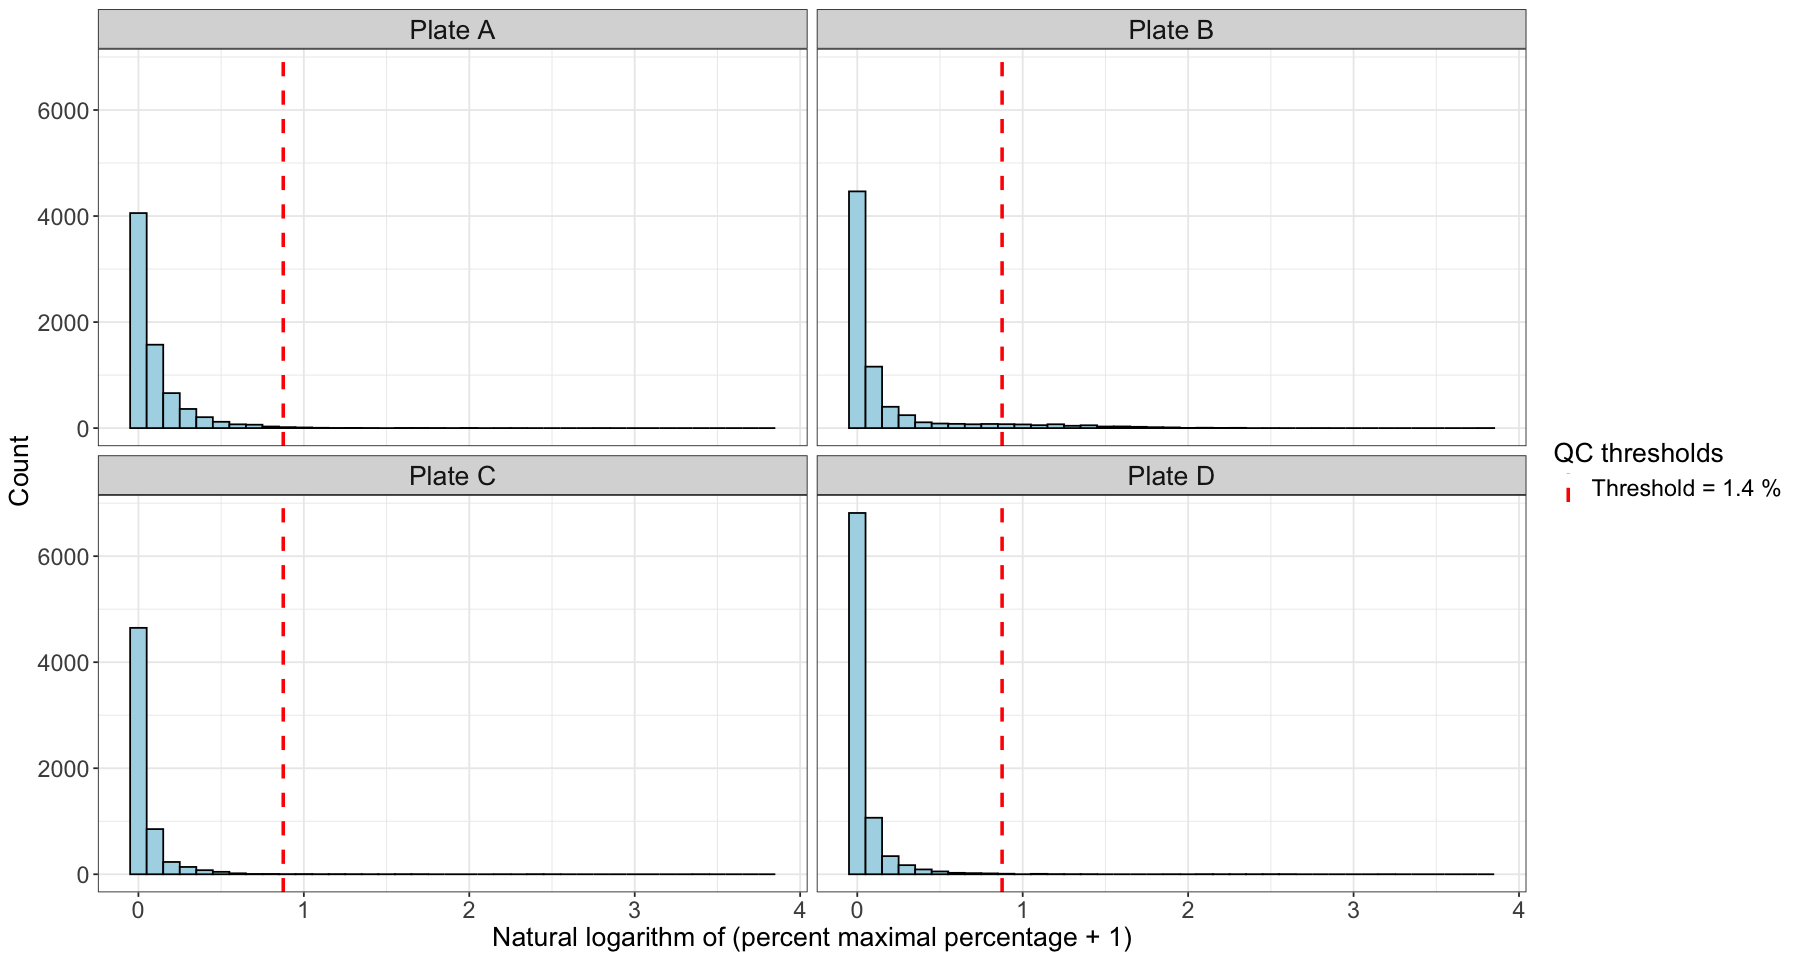

In [39]:
width <- 15
height <- 8
options(repr.plot.width = width, repr.plot.height = height)

# Take natural logarithm plus one of the percent maximal for better visualization
qc_df <- qc_df %>%
  mutate(LogImageQuality = log1p(PercentMaximal))

# Create a label for the threshold line
percentmaximal_threshold <- 1.4

# Create the plot
qc_saturation_plot <- ggplot(qc_df, aes(x = LogImageQuality)) +
  geom_histogram(binwidth = 0.1, fill = "lightblue", color = "black") +
  facet_wrap(~ Metadata_Plate) +
  geom_vline(aes(xintercept = log1p(percentmaximal_threshold), 
                 color = paste("Threshold =", percentmaximal_threshold, "%")),
             linetype = "dashed", linewidth = 1) +
  scale_color_manual(name = "QC thresholds", values = "red") + # Customize the legend title and color
  labs(
    x = "Natural logarithm of (percent maximal percentage + 1)",
    y = "Count"
  ) +
  theme_bw() +
  theme(
    strip.text = element_text(size = 16),   # Facet titles
    axis.title = element_text(size = 16),  # Axis titles
    axis.text = element_text(size = 14),   # Axis text
    legend.title = element_text(size = 16), # Legend title
    legend.text = element_text(size = 14)   # Legend text
  )

qc_saturation_plot

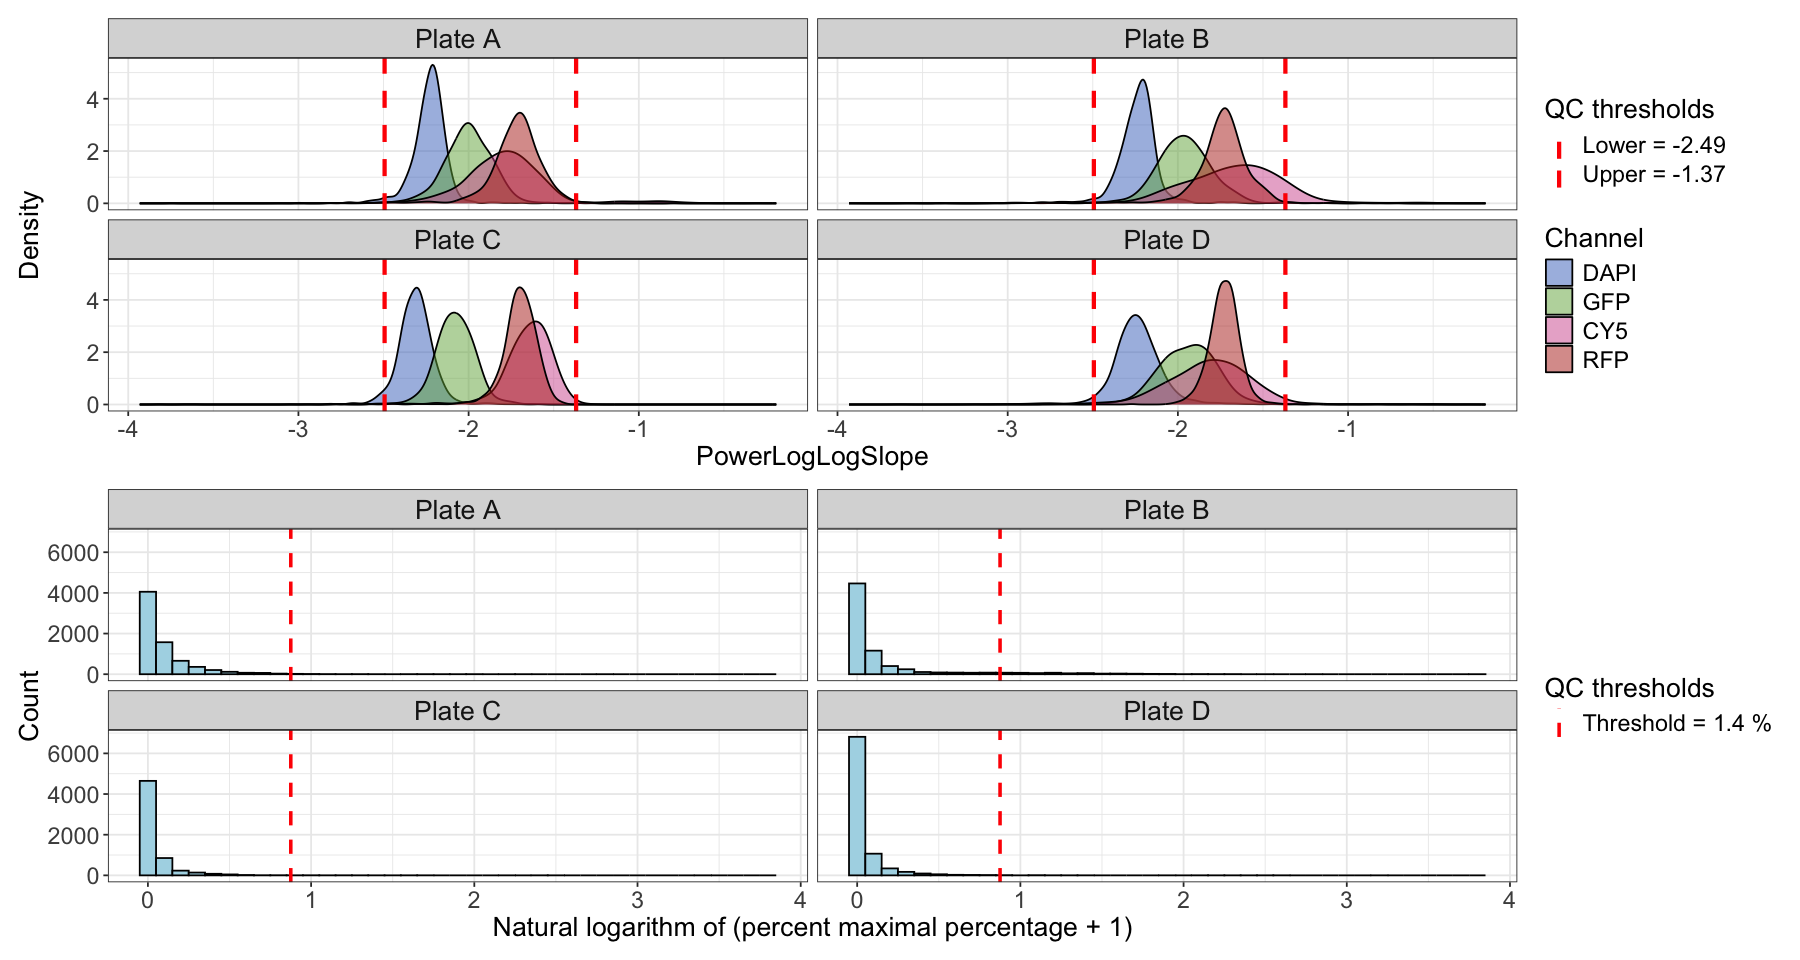

In [40]:
align_plot <- (
    qc_blur_plot /
    qc_saturation_plot 
) + plot_layout(heights= c(2,2))

align_plot

## Generate supplemental figure

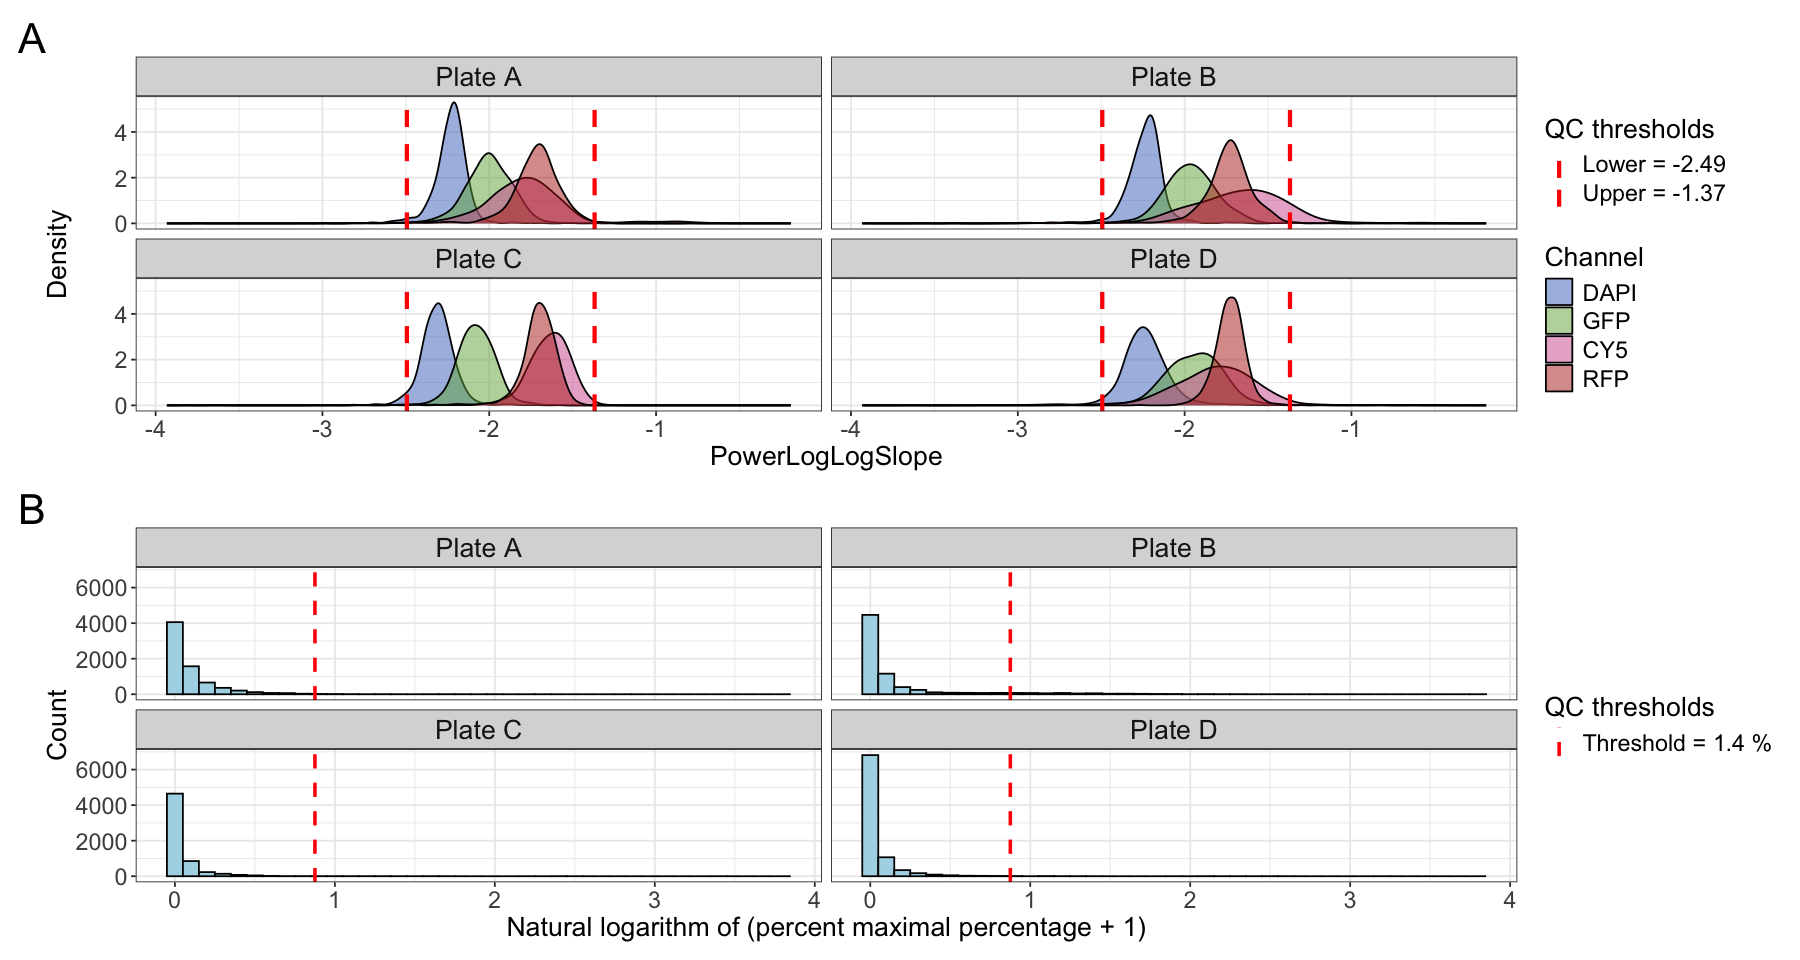

In [41]:
supp_fig_gg <- (
  align_plot
) + plot_annotation(tag_levels = "A") & theme(plot.tag = element_text(size = 25))

# Save or display the plot
ggsave(output_supp_figure, plot = supp_fig_gg, dpi = 500, height = 8, width = 10)

supp_fig_gg

## Quantify the number of FOVs that failed QC

In [42]:
# Define the directory containing Corrected_Images folders
corrected_dir <- "/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/Corrected_Images"


# List all RunImage.csv files for Plates 3, 3_prime, 5, and 6
runimage_csv_paths <- list.files(
    path = corrected_dir,
    pattern = "RunImage\\.csv$",
    recursive = TRUE,
    full.names = TRUE
) %>%
    keep(~ str_detect(.x, "Plate_3($|/)")
                | str_detect(.x, "Plate_3_prime($|/)")
                | str_detect(.x, "Plate_5($|/)")
                | str_detect(.x, "Plate_6($|/)"))

# Read all RunImage.csv files and bind into one dataframe
runimage_data_df <- runimage_csv_paths %>%
    set_names() %>%
    map_dfr(read_csv, .id = "source_file", show_col_types = FALSE)

# Check result
dim(runimage_data_df)
head(runimage_data_df)

[1] 5472  111

source_file,Channel_OrigDAPI,Channel_OrigGFP,Channel_OrigMito,Channel_OrigRFP,ExecutionTime_01Images,ExecutionTime_02Metadata,ExecutionTime_03NamesAndTypes,ExecutionTime_04Groups,ExecutionTime_05MeasureImageQuality,⋯,Series_OrigMito,Series_OrigRFP,URL_OrigDAPI,URL_OrigGFP,URL_OrigMito,URL_OrigRFP,Width_OrigDAPI,Width_OrigGFP,Width_OrigMito,Width_OrigRFP
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/Corrected_Images/Corrected_Plate_3_prime/IC_QC_RunImage.csv,-1,-1,-1,-1,0,0,1.67,0,1.18,⋯,0,0,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_1_10_DAPI_001.tif,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_2_10_GFP_001.tif,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_3_10_CY5_001.tif,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_4_10_RFP_001.tif,1224,1224,1224,1224
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/Corrected_Images/Corrected_Plate_3_prime/IC_QC_RunImage.csv,-1,-1,-1,-1,0,0,2.47,0,1.16,⋯,0,0,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_1_11_DAPI_001.tif,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_2_11_GFP_001.tif,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_3_11_CY5_001.tif,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_4_11_RFP_001.tif,1224,1224,1224,1224
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/Corrected_Images/Corrected_Plate_3_prime/IC_QC_RunImage.csv,-1,-1,-1,-1,0,0,2.09,0,1.22,⋯,0,0,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_1_12_DAPI_001.tif,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_2_12_GFP_001.tif,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_3_12_CY5_001.tif,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_4_12_RFP_001.tif,1224,1224,1224,1224
/Users/marktalbot/Documents/VC Studio Homework Folders/HighRisk/nf1_schwann_cell_painting_data/1.cellprofiler_ic/Corrected_Images/Corrected_Plate_3_prime/IC_QC_RunImage.csv,-1,-1,-1,-1,0,0,2.14,0,1.15,⋯,0,0,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_1_13_DAPI_001.tif,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_2_13_GFP_001.tif,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_3_13_CY5_001.tif,file:/Users/marktalbot/Documents/VC%20Studio%20Homework%20Folders/HighRisk/nf1_schwann_cell_painting_data/0.download_data/Plate_3_prime/B10_01_4_13_RFP_001.tif,1224,1224,1224,1224
/Users/marktalbot/Documents/VC Studio Homework Fol

In [43]:
# Count number of FOVs that failed QC
num_failed <- runimage_data_df %>% filter(Image_Quality_Control_QC_Flag == 1) %>% nrow()

# Total number of FOVs
num_total <- nrow(runimage_data_df)

# Percentage failed
percent_failed <- (num_failed / num_total) * 100

cat("Number of FOVs failed QC:", num_failed, "\n")
cat("Total number of FOVs:", num_total, "\n")
cat(sprintf("Percentage failed: %.2f%%\n", percent_failed))

Number of FOVs failed QC: 964 
Total number of FOVs: 5472 
Percentage failed: 17.62%
